# Horizon tutorial

This notebook shows how we work with surfaces inside the seismic volume of amplitudes. Before proceeding, make sure to check out our [previous tutorial on Seismic Geometries](./01_Geometry.ipynb).

Prior to horizons, we instantiate the `SeismicGeometry` instance to infer cube structure: after all, the horizon is a surface bounded to the geology. Corresponding to two main types of geometries that we can handle, there are two main horizon primitives:

- `UnstructuredHorizon` is intended to be used in pair with `SeismicGeometry` without clear spatial structure, e.g. with a pre-stack cube with `FieldRecord`/`TraceNumber` indexing headers
- `StructuredHorizon` (aliased to `Horizon`) needs a strict and regular cube layout, e.g. `iline`/`crossline` indexing headers. Due to accent on seismic interpretation tasks in our framework, this class is better developed and is well tested 

In [1]:
# All the necessary imports
import sys
import numpy as np

sys.path.append('..')
from seismiqb import SeismicGeometry, UnstructuredHorizon, Horizon, plot_image

# Unstructured Horizon

One of the task where we would like to work with a cube with no rigorous structure, yet we would like to add a horizon to it, is the first break picking: the sought-for points form a distinctly visible surface, and that is exactly the definition of a seismic horizon.

First of all, we make an instance of `SeismicGeometry` to hold all the necessary info about the cube:

In [2]:
%%time
geometry = SeismicGeometry(
    '/data/seismic/CUBE_FBP/H2_Pal_ETALON_150ffid.sgy',
    headers=SeismicGeometry.HEADERS_PRE_FULL,
    index_headers = SeismicGeometry.INDEX_PRE,
    collect_stats=True, spatial=False,
)

print(geometry)



Geometry for cube              /data/seismic/CUBE_FBP/H2_Pal_ETALON_150ffid.sgy
Current index:                 ['FieldRecord', 'TraceNumber']
Shape:                         [ 152 2335 1001]
Time delay and sample rate:    0, 2.0

Cube size:                     0.504 GB
Size of the instance:          0.112 GB

Number of traces:              354920

Num of unique amplitudes:      3217625
Mean/std of amplitudes:        -0.941476/36218.6
Min/max amplitudes:            -8.62078e+06/8.85764e+06
q01/q99 amplitudes:            -71601.5/73673.0

CPU times: user 4.74 s, sys: 1.27 s, total: 6.01 s
Wall time: 5.19 s


To make an unstructured horizon, we need to supply:

- path to the csv-like file
- reference to the geometry
- `names` of columns present in the file
- `columns` to keep from the file; should be a subset of `names`
- optionally, other parameters for [csv reader](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)

In [3]:
%%time
horizon = UnstructuredHorizon(
    '/data/seismic/CUBE_FBP/H2_Pal_ETALON_150ffid_picking.csv',
    geometry=geometry,
    names=['FieldRecord', 'TraceNumber', 'file_id', 'FIRST_BREAK_TIME'],
    columns=['FieldRecord', 'TraceNumber', 'FIRST_BREAK_TIME'],
    reader_params={'sep': ',', 'header': 0},
)

print(horizon)


Horizon H2_Pal_ETALON_150ffid_picking.csv for H2_Pal_ETALON_150ffid.sgy
Depths range:           24.0 to 501.0
Depths mean:            331.228
Depths std:             107.545
Length:                 69427

CPU times: user 734 ms, sys: 38.8 ms, total: 773 ms
Wall time: 802 ms


Due to absence of any regular structure, the main underlying storage is plain `pandas` dataframe:

In [4]:
horizon.dataframe

H2_Pal_ETALON_150ffid_picking.csv
FieldRecord TraceNumber                                   
16005       2268                                      37.0
            2269                                      36.0
            2267                                      57.0
            2270                                      51.5
            2266                                      68.0
...                                                    ...
20994       2771                                     474.5
            2047                                     479.0
            2901                                     485.5
            2106                                     471.5
            2932                                     470.0

[69427 rows x 1 columns]

One of the main purposes of horizon classes is to create segmentation mask of itself: we provide a cube location and the method adds horizon on it, if they are overlapping: that allows us to train ML models on pairs of (seismic, mask) in order to automatically generate horizons for any given seismic.

While training neural networks is out of scope of this tutorial, we can use the same method to paint the horizon line over seismic data slice:

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1155: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike



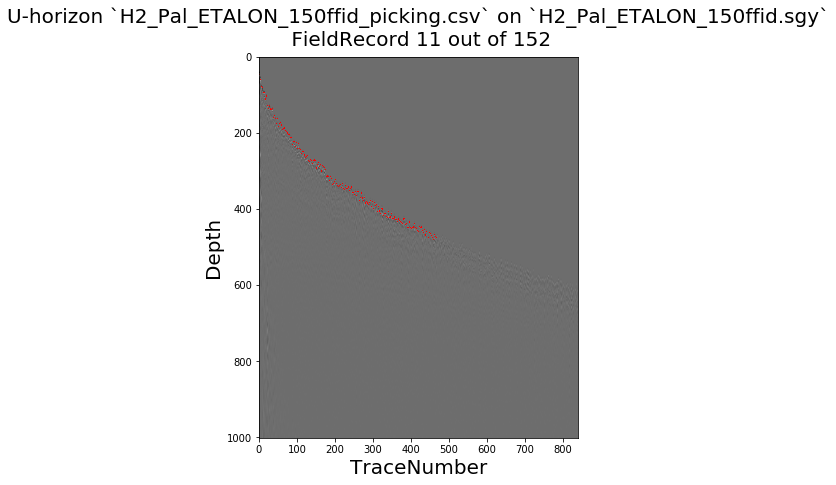

In [5]:
horizon.show_slide(11)

Currently, there is no much else to the class: hopefully, one day it will embrace all the capabilities of our [seismic processing library!](https://github.com/gazprom-neft/SeismicPro)

# Structured Horizon

Lets proceed to a structured horizon: the one that developed primarily for interpretation tasks. Obviously, it needs a structured geometry: we use the **HDF5** cube to make things fast:

In [6]:
geometry = SeismicGeometry('/data/seismic/CUBE_1/E_anon.hdf5')

print(geometry)


Geometry for cube              /data/seismic/CUBE_1/E_anon.hdf5
Current index:                 ['INLINE_3D', 'CROSSLINE_3D']
Shape:                         [2563 1409 1501]
Time delay and sample rate:    50, 2.0

Cube size:                     61.5 GB
Size of the instance:          0.947 GB

Number of traces:              3611267
Number of non-zero traces:     2435820

Num of unique amplitudes:      185
Mean/std of amplitudes:        0.00634296/1888.33
Min/max amplitudes:            -47429.4/39240.2
q01/q99 amplitudes:            -5459.5/5118.29



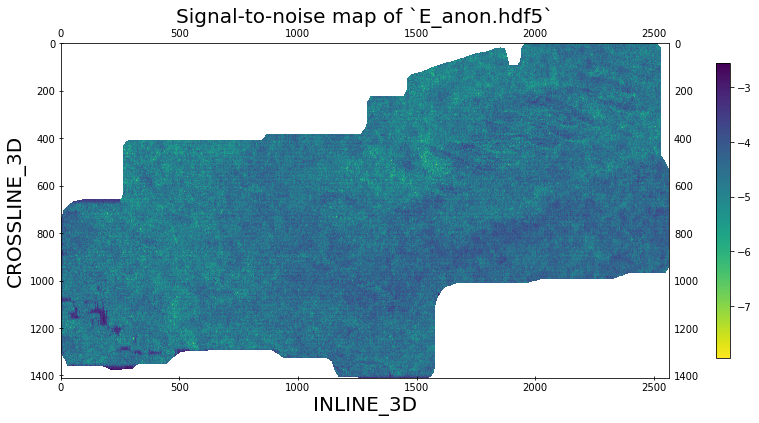

In [7]:
geometry.show_snr()

To create an instance of `Horizon`, following things must be provided:

- data container; for example, path to a csv-like file
- reference to a cube geometry

That is all! Due to the fact that this class is much more specialized, we don't need to take various indices, headers and such into account. For conveniency, a `Horizon` instance can be created from various containers:

- path to a csv-like file. We support **CHARISMA** and **GENERAL PURPOSE** geological formats
- array of shape (N, 3), where each row is a point in *(iline, crossline, depth)* format
- matrix of shape *(n_ilines, n_crosslines)* and left-upper point in the cube coordinate system
- matrix of the same shape as the cube spatial range
- mapping (dictionary) from *(iline, crossline)* pairs to *depth*

We will explore more about data containers later; now, let's load the horizon:

In [8]:
%%time
horizon = Horizon('/data/seismic/CUBE_1/RAW/etp_B_anon', geometry)

print(horizon)


Horizon etp_B_anon for E_anon.hdf5 loaded from file
Ilines range:      0 to 2559
Xlines range:      1 to 1403
Depth range:       1060 to 1214
Depth mean:        1132.64
Depth std:         36.7552

Length:            2902207
Perimeter:         8646
Coverage:          1.1915
Solidity:          1.0
Num of holes:      0

CPU times: user 2.77 s, sys: 243 ms, total: 3.01 s
Wall time: 3.01 s


There are two main underlying storages: `points` and `matrix` attributes:

- `points` is an array of shape *(N, 3)*, where each row is a point in *(iline, crossline, depth)* format
- `matrix` is an array of shape *(n_ilines, n_crosslines)*. Essentially, that is a depth-map of a horizon; we can save some space on small horizons by not keeping the full matrix, but only a part of it: that is where we need the location of upper-left point in regard to the whole cube

The reason to keep multiple storages is simple: speed and efficiency. Some of the operations can be done faster by using `points` array, while others work way better with `matrix` representation. Note that pretty much all of the attributes of `Horizon` instances are loaded lazily: if the horizon is initialized from `points` or points-like (for example, csv-file) container, then the `matrix` attribute is created at the time of the first access: that is of utmost importance when we generate thousands of horizon and merge them together. The same goes for statistics and (geological) properties, which we will show in just a few minutes.

Speaking of showing:

- `show` method allows us to check the depth map of a horizon from above
- `show_slide` visualizes desired slice of seismic data together with the horizon painted over it

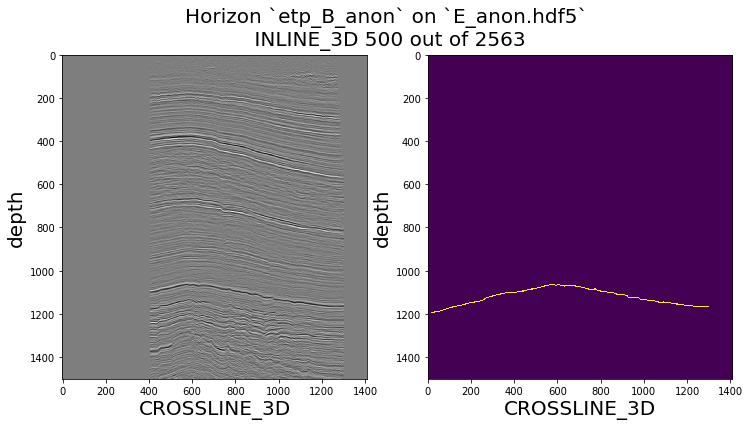

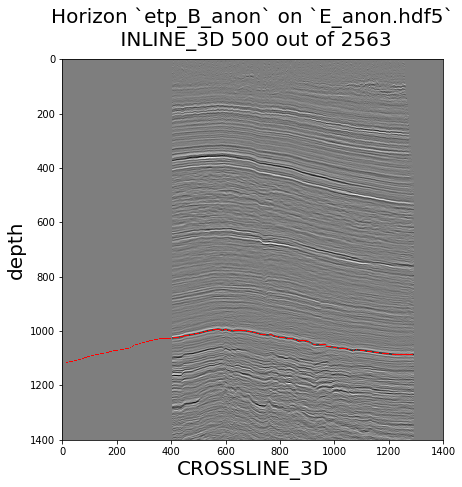

In [9]:
horizon.show_slide(500, width=5, y=0.92, mode='separate', cmap=['gray', 'viridis'])
horizon.show_slide(500)

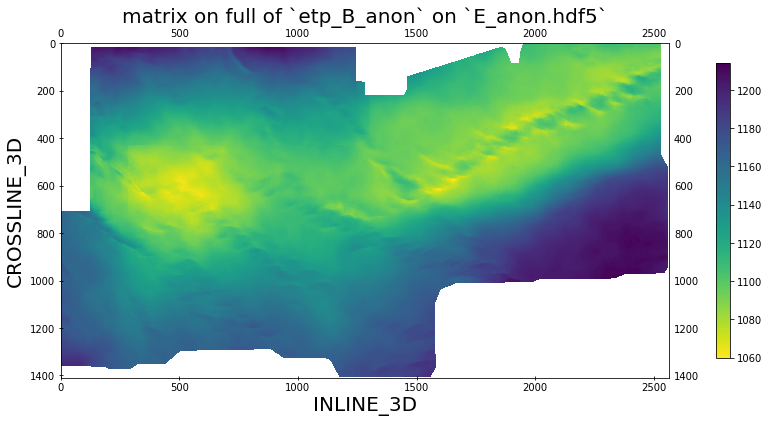

In [10]:
horizon.show()

As we can clearly see, for some reason the horizon is labeled even for some of the zero-traces; probably, that is an artifact of auto-picking procedure. We can throw away all the unneeded points by filtering:


Horizon etp_B_anon for E_anon.hdf5 loaded from file
Ilines range:      0 to 2559
Xlines range:      1 to 1403
Depth range:       1060 to 1214
Depth mean:        1130.12
Depth std:         37.6547

Length:            2424324
Perimeter:         8242
Coverage:          0.99528
Solidity:          1.0
Num of holes:      0



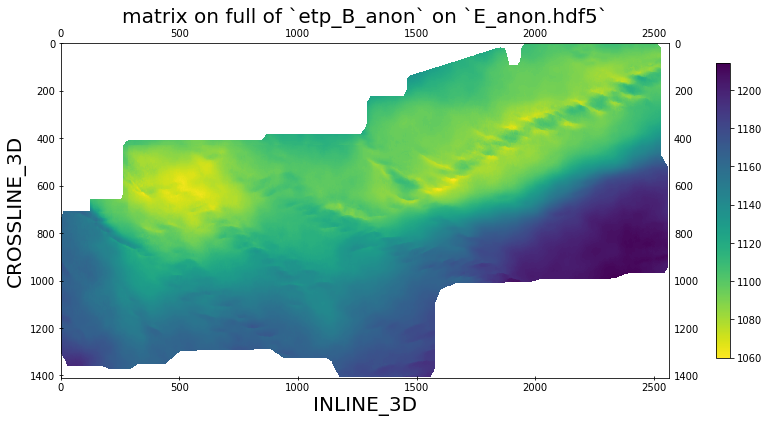

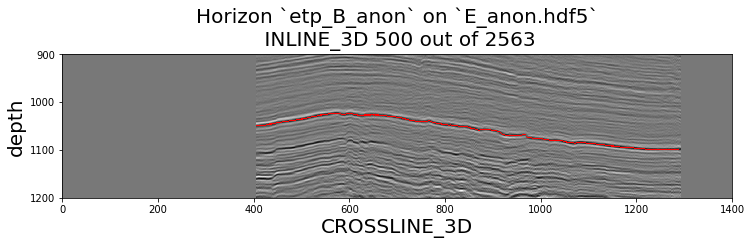

CPU times: user 1.73 s, sys: 447 ms, total: 2.17 s
Wall time: 1.68 s


In [11]:
%%time
horizon.filter()

print(horizon)

horizon.show()
horizon.show_slide(500, zoom_slice=(slice(None), slice(900, 1300)))

By default, `show` method displays the depth-map of a horizon surface. We can tell it to show other geological attributes by passing the `src` positional argument:

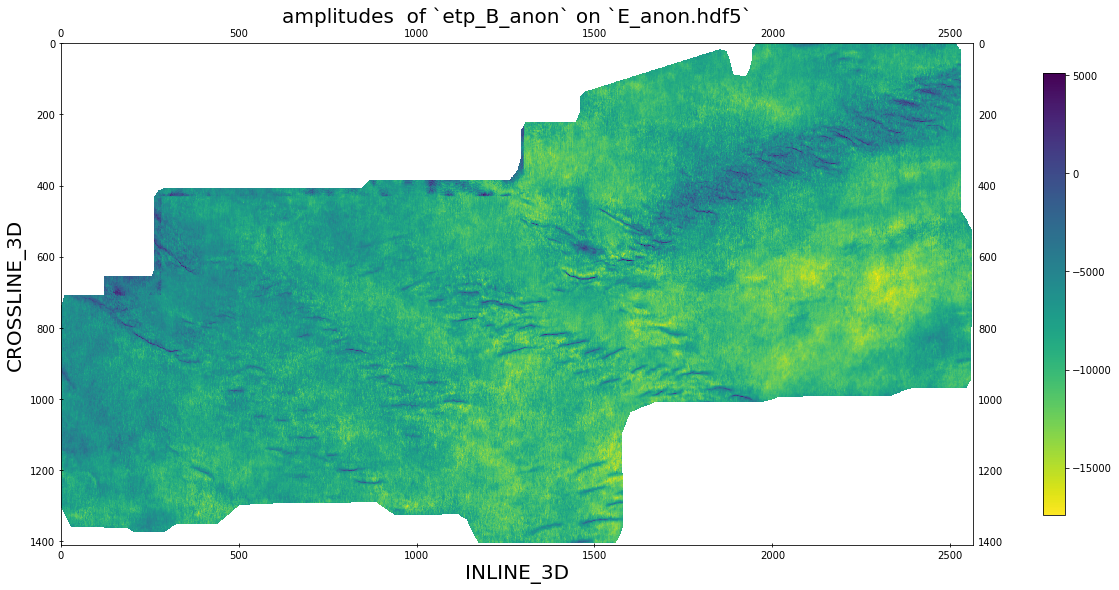

In [12]:
horizon.show('amplitudes', on_full=False, figsize=(18, 18))

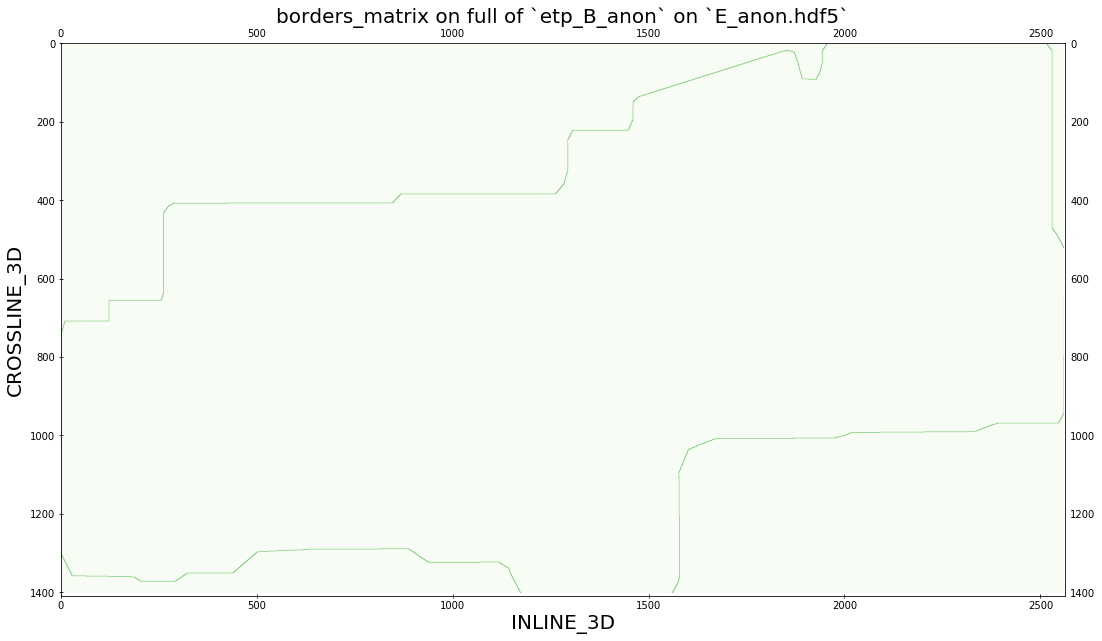

In [13]:
horizon.show('borders_matrix', interpolation='bilinear', figsize=(18, 18), cmap='Greens', colorbar=False)

The next attribute, instantaneous phase, allows us to do initial quality assessment: the horizon must be labeled along the same phase, and deviations are highly undesirable:

CPU times: user 16.2 s, sys: 2.01 s, total: 18.2 s
Wall time: 18.2 s


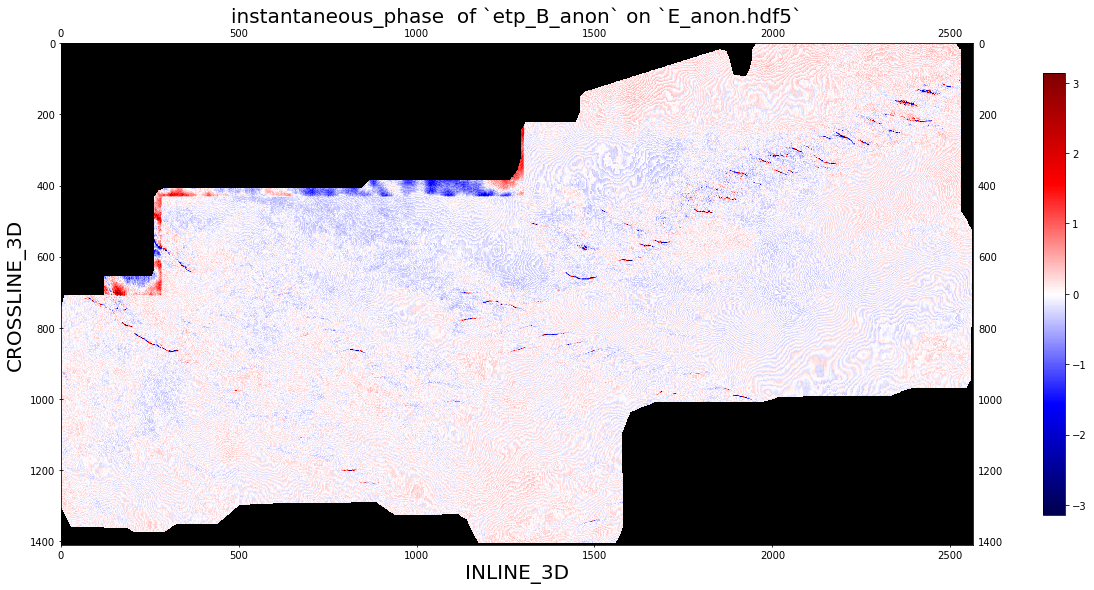

In [14]:
%%time
horizon.show('instantaneous_phase', on_full=False, figsize=(18, 18), bad_color='black', cmap='seismic')

One of the images above shows amplitudes along the horizon. For some tasks it is better to use 3 subsequent slices of amplitudes: one slice along the horizon, the one right beneath it, and the next one. These 3 slices can be used as 3 channels of an RGB image:

***The `width` parameter allows to control stride between subsequent slices.***

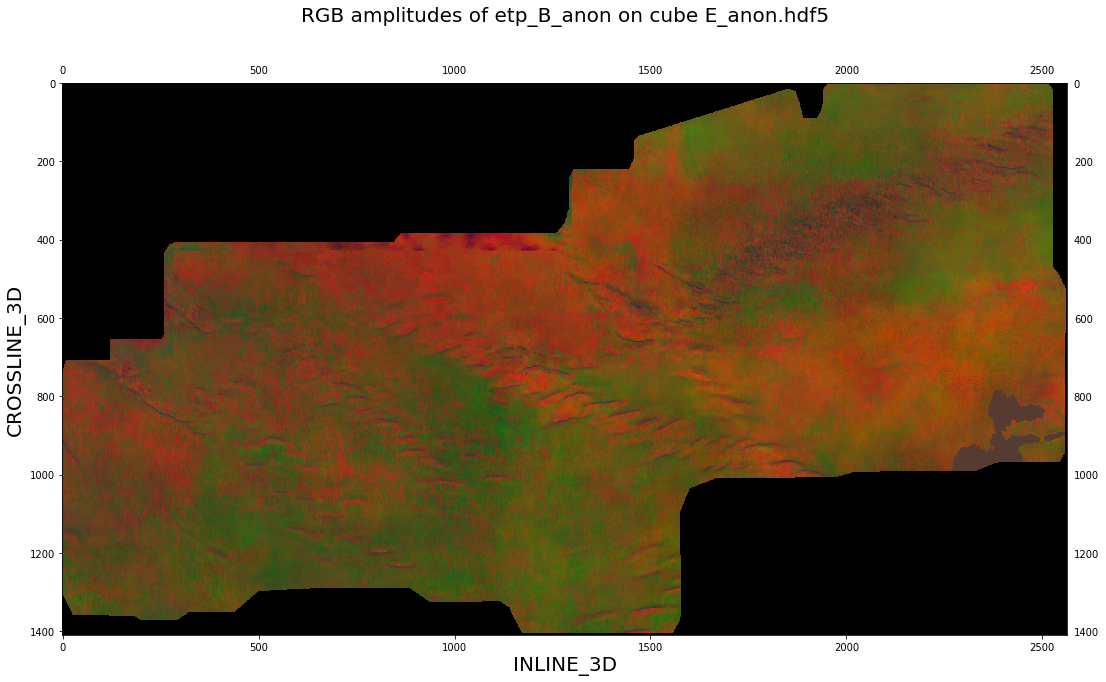

In [15]:
horizon.show_amplitudes_rgb(width=5, figsize=(18, 18))

Those simple geological attributes allow us to get a lot of insight on the horizon we are processing. To get even more, we can use `evaluate` method, which computes rich discription of the labeled surface:

- its spatial characteristics like number of points, number of holes and perimeter
- how many of the cube non-zero traces are labeled
- how many of the horizon-interior traces are labeled
- coherence map along the horizon surface. There is a wealth of various horizon-assessment maps, that is demonstrated in [this tutorial](./04_Metrics.ipynb)


Number of labeled points:                         2424324
Number of points inside borders:                  2424324
Perimeter (length of borders):                    8242
Percentage of labeled non-bad traces:             0.995280439441338
Percentage of labeled traces inside borders:      1.0
Number of holes inside borders:                   0



../seismiqb/src/metrics.py:1099: RuntimeWarning:

invalid value encountered in true_divide

../seismiqb/src/metrics.py:123: RuntimeWarning:

Mean of empty slice



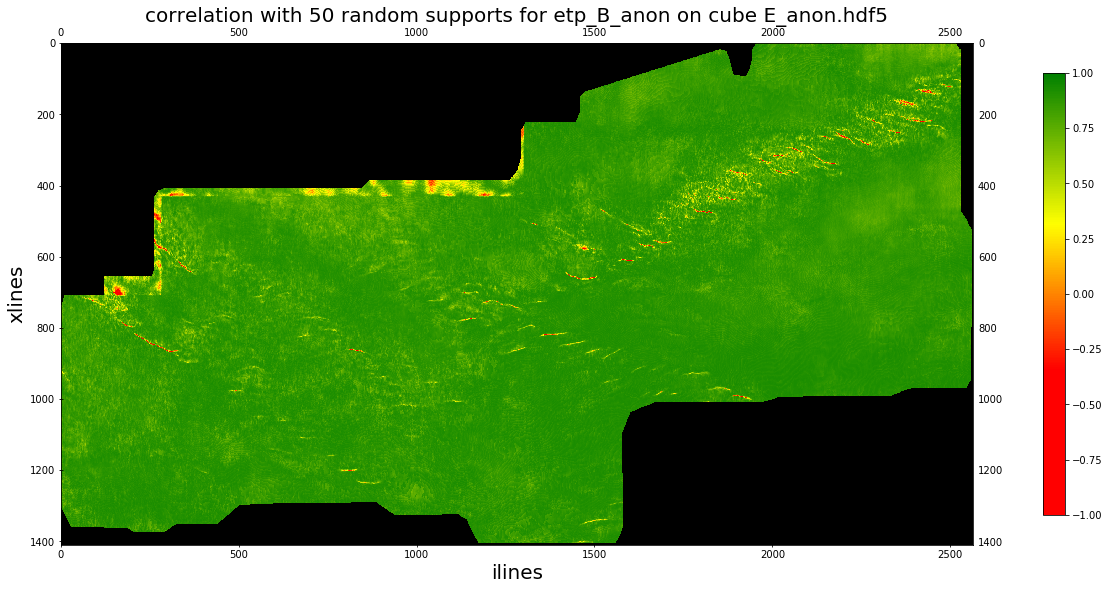

In [16]:
_ = horizon.evaluate(figsize=(18, 18), bad_color='black')

Along with the other capabilities of `Horizon` class, it can cut the data along itself from the cube of amplitudes. It can either cut one slice along specified axis, or the entire seismic volume in specified window:

Shape of cut subcube: (2563, 1, 555)
Size of the array: 0.010598190128803253 GB


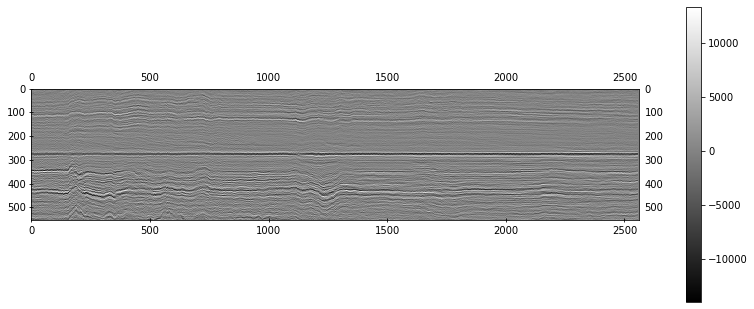

In [17]:
cut_line, _ = horizon.get_cube_values_line(window=555, line=777, orientation='x')

print(f'Shape of cut subcube: {cut_line.shape}')
print(f'Size of the array: {cut_line.nbytes / (1024 ** 3)} GB')

plot_image(np.squeeze(cut_line), cmap='gray')

In [18]:
%%time
cut_volume = horizon.get_cube_values(window=77)

print(f'Shape of cut subcube: {cut_volume.shape}')
print(f'Size of the array: {cut_volume.nbytes / (1024 ** 3)} GB')

Shape of cut subcube: (2563, 1409, 77)
Size of the array: 2.071764759719372 GB
CPU times: user 9.99 s, sys: 1.64 s, total: 11.6 s
Wall time: 11.6 s


# Merge 

As the seismic cubes are enormous in disk space and would hardly fit the tight requirements of even the most modern GPUs, we train models on 3D crops from the cube, and during the inference we do the same: every cube is split into numerous amount of crops. After making a prediction for every one of them, we can extract the horizon surface into a `Horizon` instance: note that every crop yields individual instance of the class despite the fact that they can form one cube-wide surface. This calls for a way to merge horizons, and we provide following methods to do so:

- `check_proximity` and `verify_merge` merely assess if the horizons are merge-able by answering following questions:
 - are horizons overlapping spatial-wise?
 - if they do, what is the depth-wise distance?
 - if they don't, what is the spatial-wise difference?
 
 Depending on the response, pair of horizons is deemed either:
 - `overlapping` if they have a spatial overlap and meet the threshold of heights-distance. We definetely can merge such horizons
 - `adjacent` if they don't have an overlap, but are within a margin spatial-wise. More in-depth analysis is required to decide, whether we can merge such horizons or not
 - `distant` if the horizons are too far away from each other spatial-wise. Such horizons should not be merged
 - `separated` if the horizons are too far away from each other depth-wise. Such horizons should not be merged
 
- `overlap_merge` takes two overlapping horizons and creates a new one. Where both horizons are present, mean value is taken

- `adjacent_merge` takes two non-overlapping, but spatially close horizons, checks the height difference at the closest edges of horizons and, if needed, merges them into one instance


To demostrate these functions, we create two horizons from parts of already initialized surface:

In [19]:
horizon_1 = Horizon(horizon.points[:1_400_000, :],
                    geometry=geometry, name='horizon_1')

horizon_2 = Horizon(horizon.points[1_000_000:, :],
                    geometry=geometry, name='horizon_2')

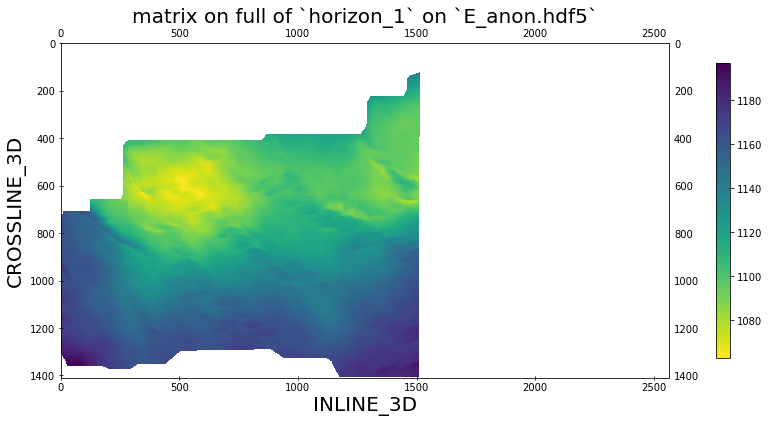

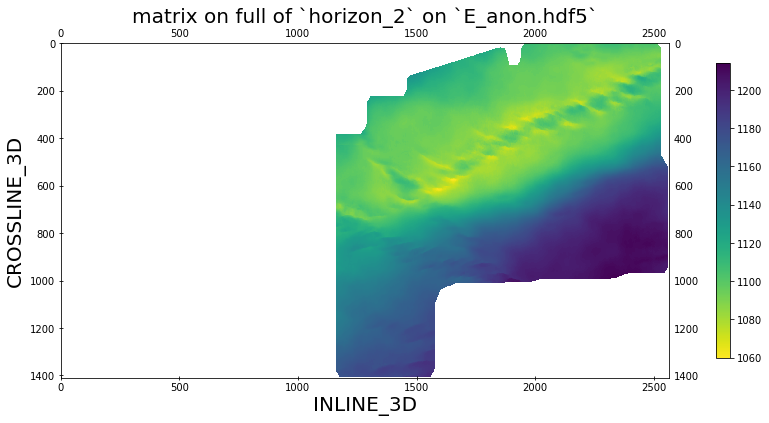

In [20]:
horizon_1.show()
horizon_2.show()

`check_proximity` returns a dictionary with stats on how close the horizons are, both spatial and heights wise, as well as `spatial_position`, that tells us that our two horizons are correctly detected as overlapping:

In [21]:
Horizon.check_proximity(horizon_1, horizon_2)

{'mean': 0.0,
 'diffs': array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
 'spatial_position': 'overlap',
 'abs_mean': 0.0,
 'max': 0,
 'abs_max': 0,
 'std': 0.0,
 'abs_std': 0.0,
 'window_rate': 1.0,
 'offset_diffs': array([0, 0, 0, ..., 0, 0, 0], dtype=int32)}

True
CPU times: user 69.2 ms, sys: 2.9 ms, total: 72.1 ms
Wall time: 70.1 ms


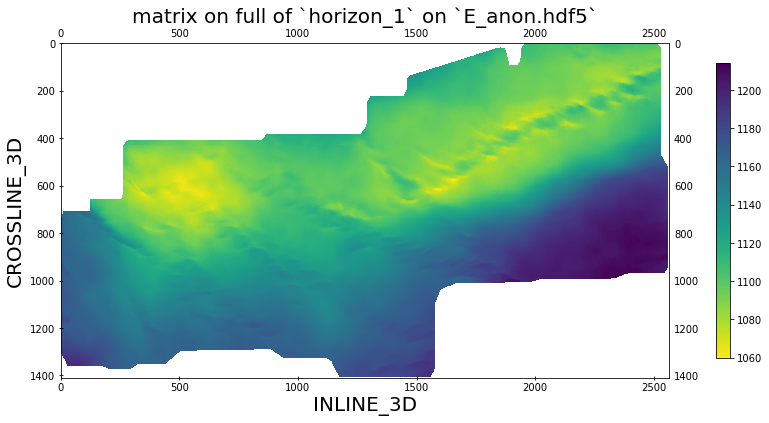

In [22]:
%%time
merged_horizon = Horizon.overlap_merge(horizon_1, horizon_2)

print(np.all(horizon.matrix==merged_horizon.matrix))
merged_horizon.show()

This concludes the tutorial on horizons. In [the next one](./03_Cubeset.ipynb), you will learn how to work with entire dataset of seismic cubes and horizons!